# Imports and Configuration


In [6]:
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import librosa
import soundfile as sf
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import (
    AutoModel, 
    AutoTokenizer, 
    RobertaModel,
    RobertaTokenizer,
WhisperForAudioClassification,
    WhisperModel,AutoModelForSequenceClassification,WhisperFeatureExtractor,
    WhisperProcessor
)
import IPython.display as ipd

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import the dataset loader
from mamkit.data.datasets import MMUSEDFallacy, InputMode

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define constants
MAX_TEXT_LEN = 128           # Maximum number of tokens for text
BATCH_SIZE = 16
NUM_CLASSES = 6
LEARNING_RATE = 2e-5
EPOCHS = 10
SEED = 42
WHISPER_MAX_LENGTH = 30      # Maximum length in seconds for Whisper audio

# Set random seeds for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Define fallacy mapping for easier reference
fallacy_mapping = {
    0: "Appeal to Emotion",
    1: "Appeal to Authority",
    2: "Ad Hominem",
    3: "False Cause",
    4: "Slippery Slope",
    5: "Slogans"
}

Using device: cuda


# Load the Models

In [32]:

# # Load the RoBERTa model and tokenizer
# # text_tokenizer = RobertaTokenizer.from_pretrained("roberta_fallacy_stage1")
# text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# # Load Whisper model and processor
# whisper_model_name = "openai/whisper-small"  # Use small model for faster processing
# whisper_processor = WhisperProcessor.from_pretrained(whisper_model_name)


In [7]:

# 1. Load your pre-trained models
# RoBERTa text model
text_model_path = "text/roberta_aug_final_metrics"
text_tokenizer = AutoTokenizer.from_pretrained(text_model_path)
text_model = AutoModelForSequenceClassification.from_pretrained(text_model_path)
text_model.eval()  # Set to evaluation mode

# Whisper audio model
audio_model_path = "./final-fallacy-classifier-whispersmall"
audio_feature_extractor = WhisperFeatureExtractor.from_pretrained(audio_model_path)
audio_model = WhisperForAudioClassification.from_pretrained(audio_model_path)
audio_model.eval()  # Set to evaluation mode

WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 768)
    (layers): ModuleList(
      (0-11): 12 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwis

# Load Dataset


In [8]:
# Load dataset
base_data_path = Path(os.getcwd()).joinpath('testdataset')
base_data_path.mkdir(parents=True, exist_ok=True)

# MM-USED-fallacy dataset with text and audio
mm_used_fallacy_loader = MMUSEDFallacy(
    task_name='afc',  # Argumentative Fallacy Classification
    input_mode=InputMode.TEXT_AUDIO,  # Using both text and audio
    base_data_path=base_data_path
)


# Examining the Dataset

In [35]:
# df = mm_used_fallacy_loader.data
# print(f"Dataset size: {len(df)} samples")
# print(df)
# print(df.columns)

In [36]:

# # Get the data

# print(f"Number of unique dialouges: {df['dialogue_id'].nunique()}")

# # Remove any None values from the fallacy column
# print(f"Number of None/NaN values in fallacy column: {df['fallacy'].isna().sum()}")
# df = df.dropna(subset=['fallacy'])
# print(f"Dataset size after removing None values: {len(df)} samples")

# # Ensure fallacy column is integer type
# df['fallacy'] = df['fallacy'].astype(int)

# # Get the class distribution
# fallacy_counts = df['fallacy'].value_counts().sort_index()
# print("\nFallacy class distribution:")
# for fallacy_id, count in fallacy_counts.items():
#     print(f"  {fallacy_mapping[fallacy_id]}: {count} samples ({count/len(df)*100:.1f}%)")

# # Visualize fallacy distribution
# plt.figure(figsize=(10, 6))
# bars = plt.bar(
#     [fallacy_mapping[i] for i in fallacy_counts.index], 
#     fallacy_counts.values
# )

# # Add value labels on top of bars
# for bar in bars:
#     height = bar.get_height()
#     plt.text(
#         bar.get_x() + bar.get_width()/2.,
#         height + 5,
#         f'{height}',
#         ha='center', 
#         va='bottom'
#     )

# plt.title('Distribution of Fallacy Classes')
# plt.xlabel('Fallacy Type')
# plt.ylabel('Count')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

In [9]:
split_info = mm_used_fallacy_loader.get_splits('mm-argfallacy-2025')[0]

# Step 3: Convert datasets (UnimodalDataset) to DataFrames
def dataset_to_df(dataset):
    return pd.DataFrame({
        "text": dataset.texts,
        "audio": dataset.audio,
        "label": dataset.labels,
    })

train_df = dataset_to_df(split_info.train)
val_df = dataset_to_df(split_info.val)
test_df_final = dataset_to_df(split_info.test)

# Get the first training sample
# First 5 samples
print(train_df.iloc[:5])
# print(split_info.train.info)

Building AFC Context: 100%|██████████| 3388/3388 [00:00<00:00, 12910.85it/s]


                                                text  \
0  And there are other ways of squeezing this bud...   
1  And you let those people go with the guideline...   
2  In mine, I happen to believe in the people and...   
3  That's why faith in the United States is pure ...   
4  They know that these toxic waste dumps should ...   

                                               audio label  
0  [D:\newargmining\testdataset\MMUSED-fallacy\au...     0  
1  [D:\newargmining\testdataset\MMUSED-fallacy\au...     0  
2  [D:\newargmining\testdataset\MMUSED-fallacy\au...     1  
3  [D:\newargmining\testdataset\MMUSED-fallacy\au...     0  
4  [D:\newargmining\testdataset\MMUSED-fallacy\au...     0  


In [118]:
print(split_info.test.labels)

[None None None ... None None None]


In [39]:
# from sklearn.model_selection import train_test_split
# from collections import Counter
# import pandas as pd

# # First: split into train (80%) and val (20%)
# train_texts, val_texts, train_labels, val_labels = train_test_split(
#     train_df["text"].tolist(),
#     train_df["label"].tolist(),
#     test_size=0.15,
#     random_state=SEED,
#     stratify=train_df["label"]
# )

In [40]:
# print("Class distribution in Train:", Counter(train_labels))
# print("Class distribution in Val:  ", Counter(val_labels))

In [10]:
# 3. Create prediction functions for both models
def get_text_predictions(texts, batch_size=16):
    all_probs = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = text_tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        
        with torch.no_grad():
            outputs = text_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1).numpy()
            all_probs.append(probs)
    
    return np.vstack(all_probs)

In [11]:
# Fix for WindowsPath issue
def clean_audio_path(path):
    """Convert WindowsPath objects to plain strings properly."""
    # If it's already a Path object
    if isinstance(path, Path):
        return str(path)
    
    # If it's a string representation of a WindowsPath
    if isinstance(path, str) and "WindowsPath" in path:
        # Remove the brackets and WindowsPath wrapper
        path = path.replace("[WindowsPath('", "").replace("')]", "")
        path = path.replace("WindowsPath('", "").replace("')", "")
        return path
    
    # If it's some other type, convert to string
    return str(path)

In [12]:
import re

def extract_path_from_string(path_str):
    """
    Extract actual file path from a string representation of WindowsPath objects.
    Handles both single paths and multiple paths in list format.
    """
    # If it's not a string (like a Path object), convert to string
    if not isinstance(path_str, str):
        return str(path_str)
    
    # Case 1: Handle path strings like "[WindowsPath('path/to/file.wav')]"
    list_pattern = re.search(r"\[WindowsPath\('([^']+)'\)\]", path_str)
    if list_pattern:
        return list_pattern.group(1)
    
    # Case 2: Handle path strings like "WindowsPath('path/to/file.wav')"
    single_pattern = re.search(r"WindowsPath\('([^']+)'\)", path_str)
    if single_pattern:
        return single_pattern.group(1)
    
    # If no pattern match but looks like a path, return as is
    return path_str

In [13]:
def get_audio_predictions(audio_paths, audio_model, audio_feature_extractor, batch_size=8):
    """
    Process audio files and get model predictions with direct path handling.
    
    Args:
        audio_paths: List of audio file paths from your DataFrame
        audio_model: Pre-trained audio model
        audio_feature_extractor: Audio feature extractor
        batch_size: Batch size for processing
        
    Returns:
        numpy array of probabilities [n_samples, n_classes]
    """
    print(f"Computing audio predictions for {len(audio_paths)} samples...")
    all_probs = []
    failed_indices = []
    
    # First pass: Process all valid files
    for i in range(0, len(audio_paths), batch_size):
        print(f"Processing batch {i}/{len(audio_paths)}")
        batch_paths = audio_paths[i:i+batch_size]
        batch_features = []
        batch_indices = []
        
        for j, path in enumerate(batch_paths):
            try:
                # Convert path to string if it's a Path object
                path_str = str(path)
                
                # Strip any brackets and WindowsPath wrapper that might have been added
                if "[WindowsPath('" in path_str:
                    # Extract the actual path
                    clean_path = path_str.split("'")[1]  # Simple string split approach
                else:
                    clean_path = path_str
                
                # Check if file exists
                if not os.path.exists(clean_path):
                    print(f"File does not exist: {clean_path}")
                    failed_indices.append(i + j)
                    continue
                
                # Load audio
                audio, sr = librosa.load(clean_path, sr=16000)
                
                # Process with feature extractor
                features = audio_feature_extractor(audio, sampling_rate=sr, return_tensors="pt")
                batch_features.append(features)
                batch_indices.append(i + j)
                
            except Exception as e:
                print(f"Error processing file #{i+j}: {e}")
                failed_indices.append(i + j)
                continue
                
        # Skip empty batches
        if not batch_features:
            continue
        
        # Process features
        try:
            inputs = {k: torch.cat([f[k] for f in batch_features]) for k in batch_features[0].keys()}
            
            with torch.no_grad():
                outputs = audio_model(**inputs)
                probs = torch.softmax(outputs.logits, dim=-1).numpy()
                
                # Store results at correct indices
                for idx, prob in zip(batch_indices, probs):
                    while len(all_probs) <= idx:
                        all_probs.append(None)
                    all_probs[idx] = prob
                
        except Exception as e:
            print(f"Error processing batch {i}: {e}")
            continue
    
    # Check if we have any valid predictions
    valid_probs = [p for p in all_probs if p is not None]
    if not valid_probs:
        raise ValueError("Failed to process any audio files successfully")
    
    # Report stats
    success_rate = len(valid_probs) / len(audio_paths) * 100
    print(f"Successfully processed {len(valid_probs)}/{len(audio_paths)} audio files ({success_rate:.1f}%)")
    
    # Calculate average probabilities for missing predictions
    avg_prob = np.mean(valid_probs, axis=0)
    
    # Create final results array, filling gaps with average
    result_probs = []
    for i in range(len(audio_paths)):
        if i < len(all_probs) and all_probs[i] is not None:
            result_probs.append(all_probs[i])
        else:
            result_probs.append(avg_prob)
    
    return np.array(result_probs)

In [55]:
train_df['audio']

0       [D:\newargmining\testdataset\MMUSED-fallacy\au...
1       [D:\newargmining\testdataset\MMUSED-fallacy\au...
2       [D:\newargmining\testdataset\MMUSED-fallacy\au...
3       [D:\newargmining\testdataset\MMUSED-fallacy\au...
4       [D:\newargmining\testdataset\MMUSED-fallacy\au...
                              ...                        
1223    [D:\newargmining\testdataset\MMUSED-fallacy\au...
1224    [D:\newargmining\testdataset\MMUSED-fallacy\au...
1225    [D:\newargmining\testdataset\MMUSED-fallacy\au...
1226    [D:\newargmining\testdataset\MMUSED-fallacy\au...
1227    [D:\newargmining\testdataset\MMUSED-fallacy\au...
Name: audio, Length: 1228, dtype: object

In [16]:

# 4. Get predictions from both models
# text_probs = get_text_predictions(train_df['text'].tolist())
# Then run the full prediction
audio_probs = get_audio_predictions(
    train_df['audio'].tolist(), 
    audio_model, 
    audio_feature_extractor
)

Computing audio predictions for 1228 samples...
Processing batch 0/1228
Processing batch 8/1228
Processing batch 16/1228
Processing batch 24/1228
Processing batch 32/1228
Processing batch 40/1228
Processing batch 48/1228
Processing batch 56/1228
Processing batch 64/1228
Processing batch 72/1228
Processing batch 80/1228
Processing batch 88/1228
Processing batch 96/1228
Processing batch 104/1228
Processing batch 112/1228
Processing batch 120/1228
Processing batch 128/1228
Processing batch 136/1228
Processing batch 144/1228
Processing batch 152/1228
Processing batch 160/1228
Processing batch 168/1228
Processing batch 176/1228
Processing batch 184/1228
Processing batch 192/1228
Processing batch 200/1228
Processing batch 208/1228
Processing batch 216/1228
Processing batch 224/1228
Processing batch 232/1228
Processing batch 240/1228
Processing batch 248/1228
Processing batch 256/1228
Processing batch 264/1228
Processing batch 272/1228
Processing batch 280/1228
Processing batch 288/1228
Proce

In [17]:
text_probs = get_text_predictions(train_df['text'].tolist())



In [18]:
# 5. Split data for fusion model training
X_combined = np.hstack([text_probs, audio_probs])
y = train_df['label'].values

In [14]:

# 4. Get predictions from both models
# Then run the full prediction
test_audio_probs = get_audio_predictions(
    test_df_final['audio'].tolist(), 
    audio_model, 
    audio_feature_extractor
)
test_text_probs = get_text_predictions(test_df_final['text'].tolist())


Computing audio predictions for 2160 samples...
Processing batch 0/2160
Processing batch 8/2160
Processing batch 16/2160
Processing batch 24/2160
Processing batch 32/2160
Processing batch 40/2160
Processing batch 48/2160
Processing batch 56/2160
Processing batch 64/2160
Processing batch 72/2160
Processing batch 80/2160
Processing batch 88/2160
Processing batch 96/2160
Processing batch 104/2160
Processing batch 112/2160
Processing batch 120/2160
Processing batch 128/2160
Processing batch 136/2160
Processing batch 144/2160
Processing batch 152/2160
Processing batch 160/2160
Processing batch 168/2160
Processing batch 176/2160
Processing batch 184/2160
Processing batch 192/2160
Processing batch 200/2160
Processing batch 208/2160
Processing batch 216/2160
Processing batch 224/2160
Processing batch 232/2160
Processing batch 240/2160
Processing batch 248/2160
Processing batch 256/2160
Processing batch 264/2160
Processing batch 272/2160
Processing batch 280/2160
Processing batch 288/2160
Proce

In [15]:
# 5. Split data for fusion model training
X_combined_inference = np.hstack([test_text_probs, test_audio_probs])
# y = train_df['label'].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)


In [20]:
# Check the type and values of y_train
print("y_train type:", type(y_train))
print("y_train sample values:", y_train[:5])

y_train type: <class 'numpy.ndarray'>
y_train sample values: [0 2 0 0 1]


In [21]:
# Check for NaN or infinite values in X_train
print("NaN values in X_train:", np.isnan(X_train).any())
print("Infinite values in X_train:", np.isinf(X_train).any())

# If there are problematic values, replace them
if np.isnan(X_train).any() or np.isinf(X_train).any():
    # Replace NaN with zeros and inf with large values
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=1e10, neginf=-1e10)

NaN values in X_train: False
Infinite values in X_train: False


In [22]:
# Check X_train type and shape
print("X_train type:", type(X_train))
print("X_train shape:", X_train.shape)
print("X_train sample:", X_train[0, :5])  # First 5 features of first sample


X_train type: <class 'numpy.ndarray'>
X_train shape: (982, 12)
X_train sample: [9.9314088e-01 1.6050338e-03 7.5871759e-04 1.3688785e-03 8.1496465e-04]


In [23]:
from imblearn.over_sampling import SMOTE


In [24]:
# Check what's actually in y_train
print("First 10 elements of y_train:", y_train[:10])
print("Data types in y_train:", [type(x) for x in y_train[:10]])

# Try to convert to integers explicitly
try:
    y_train_int = np.array([int(y) for y in y_train])
    print("Conversion successful! Shape:", y_train_int.shape)
    
    # Now try SMOTE with the converted array
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_int)
    
    print("SMOTE successful!")
    print("Original class distribution:", np.bincount(y_train_int))
    print("Resampled class distribution:", np.bincount(y_train_resampled))
    
except Exception as e:
    print("Conversion failed with error:", e)
    
    # If conversion fails, let's see what problematic values exist
    for i, val in enumerate(y_train[:100]):  # Check first 100 values
        try:
            int(val)
        except:
            print(f"Problematic value at index {i}: {val} (type: {type(val)})")

First 10 elements of y_train: [0 2 0 0 1 4 0 0 3 2]
Data types in y_train: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]
Conversion successful! Shape: (982,)
SMOTE successful!
Original class distribution: [605 152 116  45  37  27]
Resampled class distribution: [605 605 605 605 605 605]


In [68]:
# 7. Train fusion model (logistic regression)
fusion_model = LogisticRegression(max_iter=1000, class_weight='balanced')
fusion_model.fit(X_train_resampled, y_train_resampled)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
y_pred = fusion_model.predict(X_test)


In [70]:
# Check types and unique values in y_test and y_pred
print("y_test type:", type(y_test))
print("y_pred type:", type(y_pred))

y_test type: <class 'numpy.ndarray'>
y_pred type: <class 'numpy.ndarray'>


In [28]:
# Check for mixed types
print("y_test unique values:", np.unique(y_test))
# print("y_pred unique values:", np.unique(y_pred))

y_test unique values: [0 1 2 3 4 5]


In [30]:

# Convert both to integers explicitly
y_test_int = np.array([int(y) if isinstance(y, (int, float, np.number)) else -1 for y in y_test])
# y_pred_int = np.array([int(y) if isinstance(y, (int, float, np.number)) else -1 for y in y_pred])


In [74]:
# 8. Evaluate fusion model
# Try the classification report with the converted arrays
print(classification_report(y_test_int, y_pred_int))
print(f"Fusion Model Macro F1 Score: {f1_score(y_test_int, y_pred_int, average='macro'):.4f}")


              precision    recall  f1-score   support

           0       0.80      0.80      0.80       152
           1       0.61      0.74      0.67        38
           2       0.55      0.41      0.47        29
           3       0.50      0.55      0.52        11
           4       0.50      0.44      0.47         9
           5       0.40      0.29      0.33         7

    accuracy                           0.71       246
   macro avg       0.56      0.54      0.54       246
weighted avg       0.70      0.71      0.70       246

Fusion Model Macro F1 Score: 0.5438


In [80]:
# 9. Compare with individual models
text_only_preds = np.argmax(text_probs, axis=1)
audio_only_preds = np.argmax(audio_probs, axis=1)
# Convert the labels to integers
train_labels_int = np.array([int(label) for label in train_df['label']])
print("\nText-only (RoBERTa) performance:")
print(f"Macro F1 Score: {f1_score(train_labels_int, text_only_preds, average='macro'):.4f}")

print("\nAudio-only (Whisper) performance:")
print(f"Macro F1 Score: {f1_score(train_labels_int, audio_only_preds, average='macro'):.4f}")



Text-only (RoBERTa) performance:
Macro F1 Score: 0.8976

Audio-only (Whisper) performance:
Macro F1 Score: 0.8549


In [81]:
# 10. Try weighted ensemble approach
best_f1 = 0
best_weight = 0.5

for weight in np.linspace(0, 1, 21):  # Try weights from 0 to 1 with finer granularity
    weighted_probs = weight * text_probs + (1-weight) * audio_probs
    weighted_preds = np.argmax(weighted_probs, axis=1)
    f1 = f1_score(train_labels_int, weighted_preds, average='macro')
    
    if f1 > best_f1:
        best_f1 = f1
        best_weight = weight

print(f"\nBest weighted ensemble:")
print(f"- RoBERTa weight: {best_weight:.2f}")
print(f"- Whisper weight: {1-best_weight:.2f}")
print(f"- Weighted Ensemble Macro F1 Score: {best_f1:.4f}")


Best weighted ensemble:
- RoBERTa weight: 0.55
- Whisper weight: 0.45
- Weighted Ensemble Macro F1 Score: 0.9261


In [86]:
from sklearn.ensemble import RandomForestClassifier

# Instead of Logistic Regression, use Random Forest
rf_fusion_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=None,    # Max depth of trees (None means unlimited)
    min_samples_split=2,
    random_state=42,
    class_weight='balanced'  # Similar to how you handled class imbalance before
)

# Train using the same SMOTE-resampled data
rf_fusion_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
rf_pred = rf_fusion_model.predict(X_test)

# Evaluate
print(classification_report(y_test_int, rf_pred))
print(f"Random Forest Fusion Model Macro F1 Score: {f1_score(y_test_int, rf_pred, average='macro'):.4f}")

              precision    recall  f1-score   support

           0       0.79      0.76      0.77       152
           1       0.54      0.74      0.62        38
           2       0.43      0.34      0.38        29
           3       0.50      0.55      0.52        11
           4       0.50      0.44      0.47         9
           5       0.40      0.29      0.33         7

    accuracy                           0.67       246
   macro avg       0.53      0.52      0.52       246
weighted avg       0.67      0.67      0.67       246

Random Forest Fusion Model Macro F1 Score: 0.5174


In [82]:
from sklearn.ensemble import GradientBoostingClassifier

gb_fusion_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
gb_fusion_model.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(random_state=42)

In [83]:
import xgboost as xgb

xgb_fusion_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
xgb_fusion_model.fit(X_train_resampled, y_train_resampled)

d:\newargmining\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [04:11:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [87]:
from sklearn.svm import SVC

svm_fusion_model = SVC(
    kernel='rbf',
    probability=True,
    class_weight='balanced',
    random_state=42
)
svm_fusion_model.fit(X_train_resampled, y_train_resampled)

SVC(class_weight='balanced', probability=True, random_state=42)

In [88]:
from sklearn.ensemble import VotingClassifier

# Create a voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, class_weight='balanced')),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svm', SVC(probability=True, class_weight='balanced', random_state=42))
    ],
    voting='soft'  # Use probability predictions for voting
)
voting_clf.fit(X_train_resampled, y_train_resampled)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svm',
                              SVC(class_weight='balanced', probability=True,
                                  random_state=42))],
                 voting='soft')

In [89]:
from sklearn.model_selection import cross_val_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, class_weight='balanced')
}

# Compare models
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro')
    print(f"{name} - Mean F1-Macro: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    # Train on full training set
    model.fit(X_train_resampled, y_train_resampled)
    test_pred = model.predict(X_test)
    test_f1 = f1_score(y_test_int, test_pred, average='macro')
    print(f"{name} - Test F1-Macro: {test_f1:.4f}\n")

Logistic Regression - Mean F1-Macro: 0.9959 (±0.0023)
Logistic Regression - Test F1-Macro: 0.5438

Random Forest - Mean F1-Macro: 0.9948 (±0.0051)
Random Forest - Test F1-Macro: 0.5174

Gradient Boosting - Mean F1-Macro: 0.9943 (±0.0055)
Gradient Boosting - Test F1-Macro: 0.5277

SVM - Mean F1-Macro: 0.9970 (±0.0022)
SVM - Test F1-Macro: 0.5523



In [90]:
from sklearn.model_selection import GridSearchCV

# Example for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(
    SVC(probability=True, class_weight='balanced'),
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    verbose=1
)

grid_search.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             scoring='f1_macro', verbose=1)

Best F1-macro score: 0.9975159230133087

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       152
           1       0.54      0.71      0.61        38
           2       0.57      0.41      0.48        29
           3       0.60      0.55      0.57        11
           4       0.56      0.56      0.56         9
           5       0.40      0.29      0.33         7

    accuracy                           0.69       246
   macro avg       0.57      0.55      0.56       246
weighted avg       0.69      0.69      0.69       246


Confusion Matrix:
[[118  21   7   2   1   3]
 [  7  27   2   1   1   0]
 [ 15   1  12   1   0   0]
 [  3   0   0   6   2   0]
 [  4   0   0   0   5   0]
 [  4   1   0   0   0   2]]


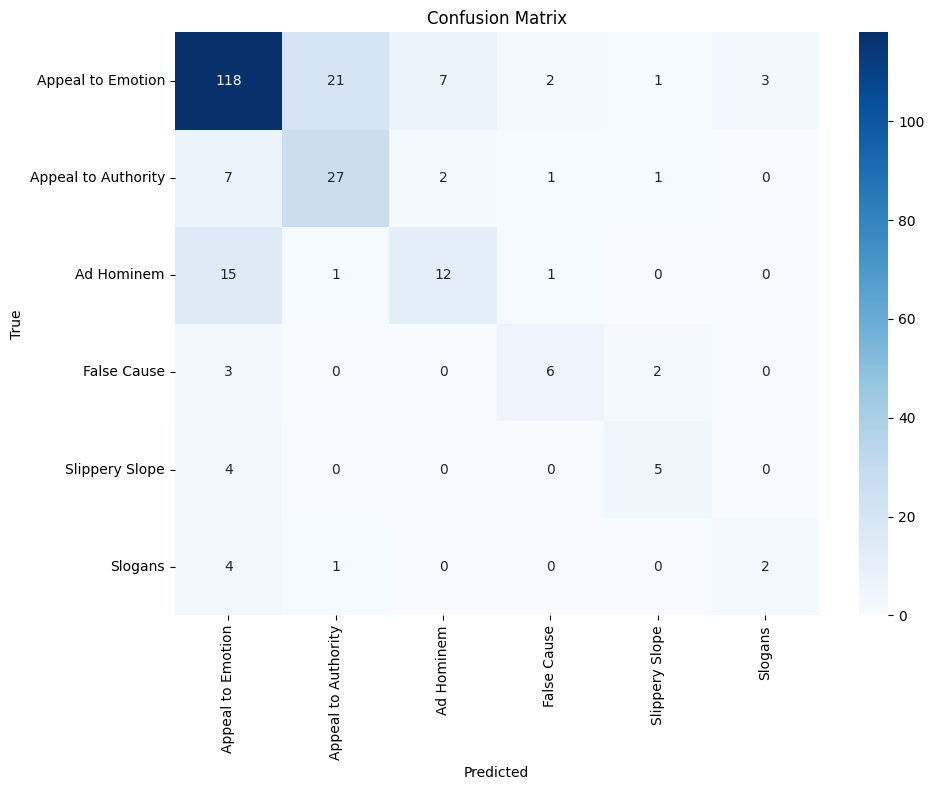

Class 0 (Appeal to Emotion): F1 = 0.7789
Class 1 (Appeal to Authority): F1 = 0.6136
Class 2 (Ad Hominem): F1 = 0.4800
Class 3 (False Cause): F1 = 0.5714
Class 4 (Slippery Slope): F1 = 0.5556
Class 5 (Slogans): F1 = 0.3333


In [95]:
# After running grid_search.fit()

# 1. Get the best parameters
# print("Best parameters:", grid_search.best_params_)

# 2. Get the best score
# print("Best F1-macro score:", grid_search.best_score_)

# # 3. Get detailed CV results
# cv_results = pd.DataFrame(grid_search.cv_results_)
# print(cv_results[['params', 'mean_test_score', 'rank_test_score']].sort_values('rank_test_score'))

# # 4. Get predictions using the best estimator
# best_svm = grid_search.best_estimator_
# y_pred = best_svm.predict(X_test)

# # 5. Get probabilities for each class
# y_prob = best_svm.predict_proba(X_test)

# 6. Get detailed classification metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(y_test_int, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_int, y_pred)
print(cm)

# 7. Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=fallacy_mapping.values(),
            yticklabels=fallacy_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 8. Examine per-class F1 scores 
from sklearn.metrics import f1_score

# Per-class F1
f1_per_class = f1_score(y_test_int, y_pred, average=None)
for i, f1 in enumerate(f1_per_class):
    print(f"Class {i} ({fallacy_mapping[i]}): F1 = {f1:.4f}")

In [ ]:
y_pred = fusion_model.predict(X_test)


In [25]:
import numpy as np
import xgboost as xgb

def weighted_multiclass_log_loss(y_true, y_pred):
    """
    Custom objective function for XGBoost that weights classes inversely to their frequency
    
    Args:
        y_true: Target class labels
        y_pred: Predicted raw scores (before softmax)
        
    Returns:
        grad: First order gradient
        hess: Second order gradient
    """
    # Get class weights (inversely proportional to class frequency)
    classes, counts = np.unique(y_true, return_counts=True)
    total_samples = len(y_true)
    class_weights = {cls: total_samples / (len(classes) * count) for cls, count in zip(classes, counts)}
    
    # Get number of classes from prediction shape
    n_classes = y_pred.shape[1]
    
    # Transform raw scores to probabilities using softmax
    y_pred = y_pred.reshape((-1, n_classes))
    preds = np.exp(y_pred - np.max(y_pred, axis=1, keepdims=True))
    preds = preds / np.sum(preds, axis=1, keepdims=True)
    
    # Create one-hot encoded targets
    y_onehot = np.zeros((len(y_true), n_classes))
    for i, label in enumerate(y_true):
        y_onehot[i, int(label)] = 1
    
    # Apply class weights to gradients and hessians
    weights = np.ones(len(y_true))
    for i, label in enumerate(y_true):
        weights[i] = class_weights[int(label)]
    
    # Calculate gradients and hessians
    grad = weights[:, np.newaxis] * (preds - y_onehot)
    hess = weights[:, np.newaxis] * preds * (1 - preds)
    
    return grad.flatten(), hess.flatten()

# Use the custom objective in XGBoost
xgb_model = xgb.XGBClassifier(
    objective=weighted_multiclass_log_loss,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# Train model with custom objective
xgb_model.fit(X_train_resampled, y_train_resampled)

d:\newargmining\.venv\lib\site-packages\xgboost\core.py:2291: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

XGBoost with Custom Loss - Performance Metrics:
Accuracy: 0.7114
Macro F1: 0.5586
Weighted F1: 0.7049

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       152
           1       0.59      0.79      0.67        38
           2       0.53      0.34      0.42        29
           3       0.46      0.55      0.50        11
           4       0.56      0.56      0.56         9
           5       0.67      0.29      0.40         7

    accuracy                           0.71       246
   macro avg       0.60      0.55      0.56       246
weighted avg       0.71      0.71      0.70       246


Confusion Matrix:
[[122  16   7   4   2   1]
 [  5  30   2   1   0   0]
 [ 13   4  10   2   0   0]
 [  3   0   0   6   2   0]
 [  4   0   0   0   5   0]
 [  4   1   0   0   0   2]]

F1 Score per class:
Class 0 (Appeal to Emotion): F1 = 0.8053
Class 1 (Appeal to Authority): F1 = 0.6742
Class 2 (Ad Hominem): F1 = 0.4167
Class 3 (F

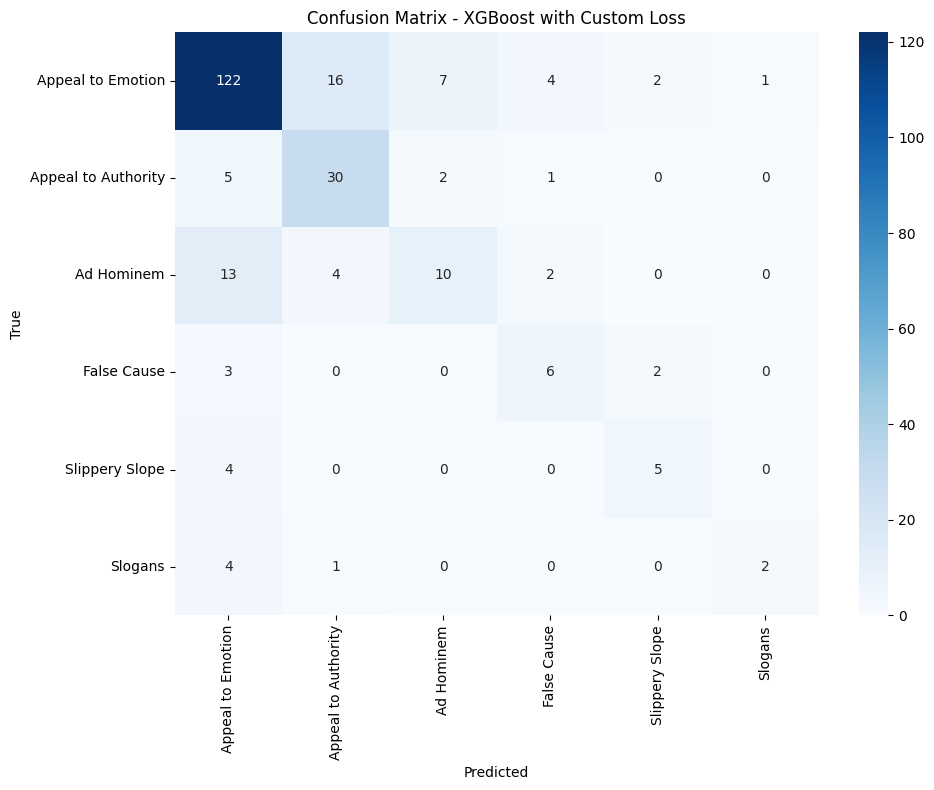

In [31]:
# Get predictions
y_pred_xgb = xgb_model.predict(X_test)

# Get probability scores
y_prob_xgb = xgb_model.predict_proba(X_test)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Print overall performance metrics
print("XGBoost with Custom Loss - Performance Metrics:")
print(f"Accuracy: {np.mean(y_pred_xgb == y_test):.4f}")
print(f"Macro F1: {f1_score(y_test_int, y_pred_xgb, average='macro'):.4f}")
print(f"Weighted F1: {f1_score(y_test_int, y_pred_xgb, average='weighted'):.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_int, y_pred_xgb))

# Print confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_int, y_pred_xgb)
print(cm)

# Per-class F1 scores
f1_per_class = f1_score(y_test_int, y_pred_xgb, average=None)
print("\nF1 Score per class:")
for i, f1 in enumerate(f1_per_class):
    print(f"Class {i} ({fallacy_mapping[i]}): F1 = {f1:.4f}")

# Visualize results if needed
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=fallacy_mapping.values(),
            yticklabels=fallacy_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost with Custom Loss')
plt.tight_layout()
plt.show()

In [32]:
y_pred_xgb = xgb_model.predict(X_test)


In [33]:
def focal_loss_objective(y_true, y_pred, gamma=2.0):
    """
    Focal Loss objective function for XGBoost
    Focuses more on hard-to-classify examples
    
    Args:
        y_true: Target class labels
        y_pred: Predicted raw scores (before softmax)
        gamma: Focusing parameter (higher values focus more on hard examples)
        
    Returns:
        grad: First order gradient
        hess: Second order gradient
    """
    # Get number of classes
    n_classes = y_pred.shape[1]
    
    # Apply softmax to get probabilities
    y_pred = y_pred.reshape((-1, n_classes))
    preds = np.exp(y_pred - np.max(y_pred, axis=1, keepdims=True))
    preds = preds / np.sum(preds, axis=1, keepdims=True)
    
    # One-hot encode targets
    y_onehot = np.zeros((len(y_true), n_classes))
    for i, label in enumerate(y_true):
        y_onehot[i, int(label)] = 1
    
    # Calculate focal weights
    # (1-pt)^gamma where pt is the probability of true class
    pt = np.sum(y_onehot * preds, axis=1)
    focal_weights = np.power(1 - pt, gamma)
    
    # Apply focal weights to gradients and hessians
    grad = focal_weights[:, np.newaxis] * (preds - y_onehot)
    hess = focal_weights[:, np.newaxis] * preds * (1 - preds)
    
    return grad.flatten(), hess.flatten()

In [ ]:

# Use the custom objective in XGBoost
xgb_model = xgb.XGBClassifier(
    objective=focal_loss_objective,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# Train model with custom objective
xgb_model.fit(X_train_resampled, y_train_resampled)

d:\newargmining\.venv\lib\site-packages\xgboost\core.py:2291: FutureWarning: Since 2.1.0, the shape of the gradient and hessian is required to be (n_samples, n_targets) or (n_samples, n_classes).
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

XGBoost with Custom Loss - Performance Metrics:
Accuracy: 0.7033
Macro F1: 0.5355
Weighted F1: 0.7003

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       152
           1       0.58      0.79      0.67        38
           2       0.55      0.38      0.45        29
           3       0.40      0.55      0.46        11
           4       0.57      0.44      0.50         9
           5       0.40      0.29      0.33         7

    accuracy                           0.70       246
   macro avg       0.55      0.54      0.54       246
weighted avg       0.71      0.70      0.70       246


Confusion Matrix:
[[120  17   7   4   1   3]
 [  5  30   2   1   0   0]
 [ 12   3  11   3   0   0]
 [  3   0   0   6   2   0]
 [  4   0   0   1   4   0]
 [  3   2   0   0   0   2]]

F1 Score per class:
Class 0 (Appeal to Emotion): F1 = 0.8027
Class 1 (Appeal to Authority): F1 = 0.6667
Class 2 (Ad Hominem): F1 = 0.4490
Class 3 (F

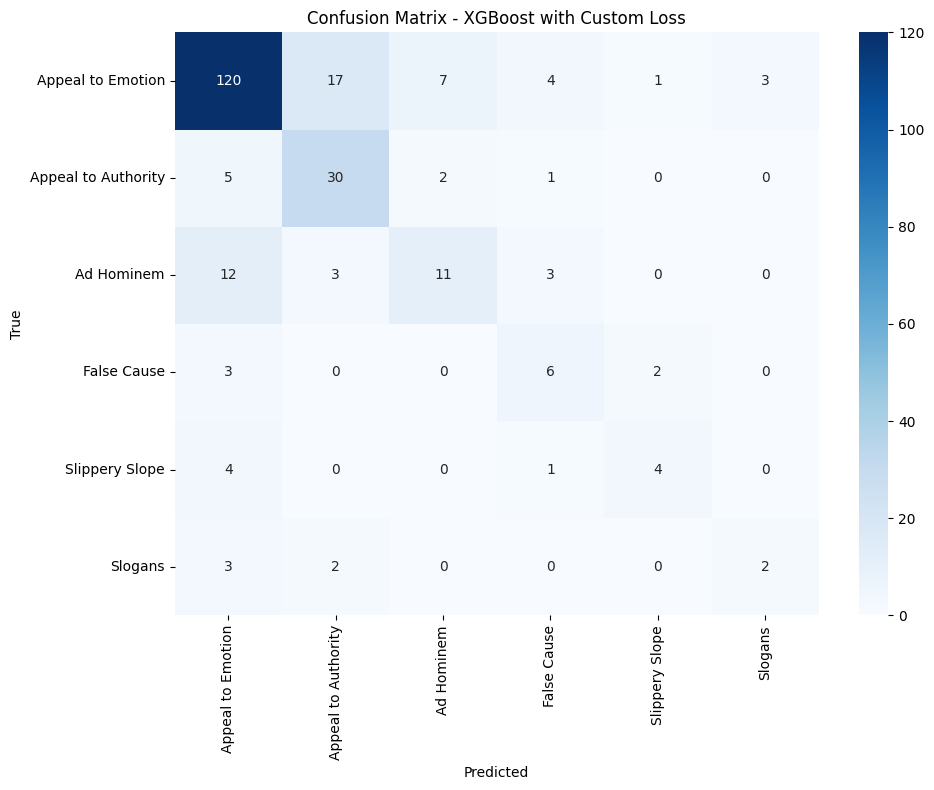

In [ ]:
# Get predictions
y_pred_xgb = xgb_model.predict(X_test)

# Get probability scores
y_prob_xgb = xgb_model.predict_proba(X_test)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Print overall performance metrics
print("XGBoost with Custom Loss - Performance Metrics:")
print(f"Accuracy: {np.mean(y_pred_xgb == y_test):.4f}")
print(f"Macro F1: {f1_score(y_test_int, y_pred_xgb, average='macro'):.4f}")
print(f"Weighted F1: {f1_score(y_test_int, y_pred_xgb, average='weighted'):.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_int, y_pred_xgb))

# Print confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_int, y_pred_xgb)
print(cm)

# Per-class F1 scores
f1_per_class = f1_score(y_test_int, y_pred_xgb, average=None)
print("\nF1 Score per class:")
for i, f1 in enumerate(f1_per_class):
    print(f"Class {i} ({fallacy_mapping[i]}): F1 = {f1:.4f}")

# Visualize results if needed
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=fallacy_mapping.values(),
            yticklabels=fallacy_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost with Custom Loss')
plt.tight_layout()
plt.show()

In [34]:
# Inference on test set using combined text and audio features

import numpy as np
import pandas as pd
import torch

# 1. First, ensure we have the test data features
print("Checking if features are already extracted...")

# Verify if the features are already extracted
features_ready = False
try:
    # Check if these variables already exist in your environment
    if 'test_text_probs' in locals() and 'test_audio_probs' in locals() and 'X_combined_inference' in locals():
        features_ready = True
        print("Features already extracted.")
except:
    print("Features not found.")

# 3. Convert to PyTorch tensor if using PyTorch model (or use as is for sklearn models)
if "xgb_model" in locals():
    # For XGBoost model
    print("Using XGBoost model for inference...")
    test_predictions = xgb_model.predict(X_combined_inference)
    test_probabilities = xgb_model.predict_proba(X_combined_inference)

# 4. Create a DataFrame with the results
results_df = pd.DataFrame({
    'text': test_df_final['text'],
    'audio': test_df_final['audio'],
    'predicted_label': test_predictions,
    'predicted_fallacy': [fallacy_mapping[int(pred)] for pred in test_predictions],
})

# 5. Add probability scores for each class
for i in range(NUM_CLASSES):
    results_df[f'prob_{fallacy_mapping[i]}'] = test_probabilities[:, i]

# 6. Save to CSV
csv_filename = 'multimodal_test_predictions_XGBOOST.csv'
results_df.to_csv(csv_filename, index=False)
print(f"Saved predictions to {csv_filename}")

# 7. Print summary of predictions
print("\nFirst 5 predictions:")
for i in range(min(5, len(test_predictions))):
    pred_class = int(test_predictions[i])
    pred_fallacy = fallacy_mapping[pred_class]
    confidence = test_probabilities[i, pred_class]
    print(f"Sample {i+1}: {pred_fallacy} (Class {pred_class}) with {confidence:.4f} confidence")

# 8. Print class distribution in predictions
class_counts = np.bincount(test_predictions.astype(int), minlength=NUM_CLASSES)
print("\nPrediction class distribution:")
for i in range(NUM_CLASSES):
    count = class_counts[i]
    percentage = count/len(test_predictions)*100
    print(f"Class {i} ({fallacy_mapping[i]}): {count} samples ({percentage:.1f}%)")

Checking if features are already extracted...
Features already extracted.
Using XGBoost model for inference...
Saved predictions to multimodal_test_predictions_XGBOOST.csv

First 5 predictions:
Sample 1: Appeal to Emotion (Class 0) with 0.9991 confidence
Sample 2: Appeal to Emotion (Class 0) with 0.9997 confidence
Sample 3: Appeal to Emotion (Class 0) with 0.9991 confidence
Sample 4: Appeal to Emotion (Class 0) with 0.9992 confidence
Sample 5: Ad Hominem (Class 2) with 0.9985 confidence

Prediction class distribution:
Class 0 (Appeal to Emotion): 1390 samples (64.4%)
Class 1 (Appeal to Authority): 267 samples (12.4%)
Class 2 (Ad Hominem): 323 samples (15.0%)
Class 3 (False Cause): 81 samples (3.8%)
Class 4 (Slippery Slope): 31 samples (1.4%)
Class 5 (Slogans): 68 samples (3.1%)


In [ ]:
print(fallacy_mapping)
print([fallacy_mapping[i] for i in range(NUM_CLASSES)])


{0: 'Appeal to Emotion', 1: 'Appeal to Authority', 2: 'Ad Hominem', 3: 'False Cause', 4: 'Slippery Slope', 5: 'Slogans'}
['Appeal to Emotion', 'Appeal to Authority', 'Ad Hominem', 'False Cause', 'Slippery Slope', 'Slogans']


Classification Report (Late Fusion):
                     precision    recall  f1-score   support

  Appeal to Emotion       0.94      0.98      0.96       757
Appeal to Authority       0.94      0.91      0.92       190
         Ad Hominem       0.94      0.93      0.94       145
        False Cause       0.96      0.89      0.93        56
     Slippery Slope       0.95      0.85      0.90        46
            Slogans       1.00      0.76      0.87        34

           accuracy                           0.95      1228
          macro avg       0.96      0.89      0.92      1228
       weighted avg       0.95      0.95      0.94      1228



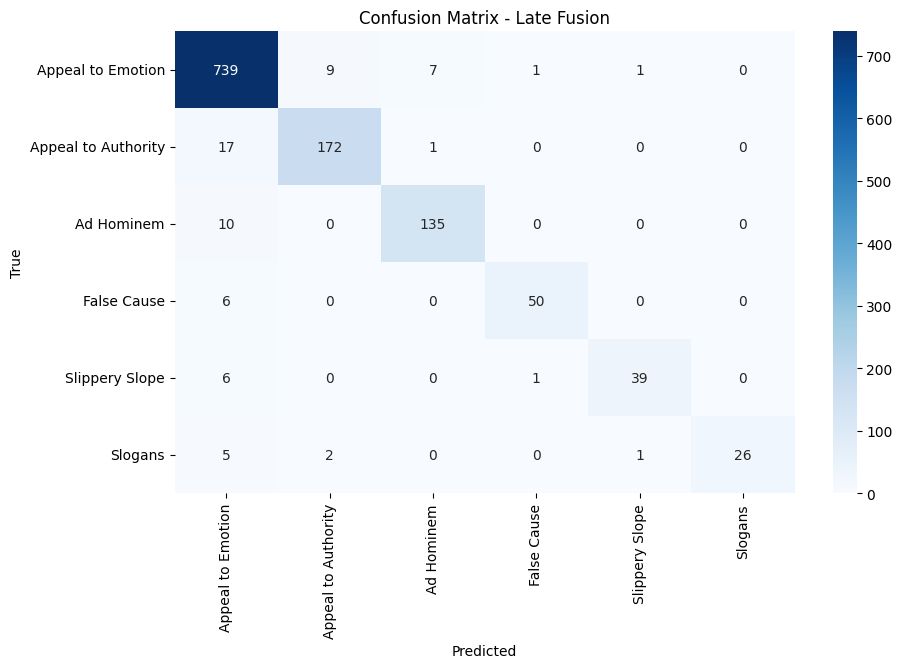

In [113]:
# ============================
# Step 2: Apply late fusion
# ============================

# Simple average fusion (can be weighted if needed)
fused_probs = (text_probs + audio_probs) / 2
fused_preds = np.argmax(fused_probs, axis=1)

# ============================
# Step 3: Evaluation
# ============================

# Print evaluation metrics
print("Classification Report (Late Fusion):")
print(classification_report(train_labels_int, fused_preds, target_names=[fallacy_mapping[i] for i in range(NUM_CLASSES)]))

# Confusion Matrix
cm = confusion_matrix(train_labels_int, fused_preds)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(fallacy_mapping.values()), 
            yticklabels=list(fallacy_mapping.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Late Fusion")
plt.show()


In [111]:
print(set(true_labels))
print(set(fused_preds))


{None}
{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)}


In [ ]:
# # 1. Process the test set to get text and audio features
# print("Extracting text features from test set...")
# test_text_probs = get_text_predictions(test_df['text'].tolist())

# print("Extracting audio features from test set...")
# test_audio_probs = get_audio_predictions(
#     test_df['audio'].tolist(), 
#     audio_model, 
#     audio_feature_extractor
# )

# # 2. Combine features for the XGBoost model
# X_combined_inference = np.hstack([test_text_probs, test_audio_probs])

# # 3. Apply the trained XGBoost model to the test set
# print("Applying XGBoost model to test set...")
# test_predictions = xgb_model.predict(X_combined_inference)
# test_probabilities = xgb_model.predict_proba(X_combined_inference)

In [ ]:
# # 4. Create a DataFrame with the results
# results_df = pd.DataFrame({
#     'text': test_df['text'],
#     'audio': test_df['audio'],
#     'predicted_label': test_predictions,
#     'predicted_fallacy': [fallacy_mapping[int(pred)] for pred in test_predictions],
# })

# # 5. Add probability scores for each class
# for i in range(NUM_CLASSES):
#     results_df[f'prob_{fallacy_mapping[i]}'] = test_probabilities[:, i]


In [ ]:
csv_filename = 'xgboost_test_predictions.csv'
results_df.to_csv(csv_filename, index=False)
print(f"Saved predictions to {csv_filename}")

# Print out the first few predictions
print("\nFirst 5 predictions:")
for i in range(min(5, len(test_predictions))):
    pred_class = int(test_predictions[i])
    pred_fallacy = fallacy_mapping[pred_class]
    confidence = test_probabilities[i, pred_class]
    print(f"Sample {i+1}: {pred_fallacy} (Class {pred_class}) with {confidence:.4f} confidence")

# Print class distribution in predictions
class_counts = np.bincount(test_predictions.astype(int), minlength=NUM_CLASSES)
print("\nPrediction class distribution:")
for i in range(NUM_CLASSES):
    print(f"Class {i} ({fallacy_mapping[i]}): {class_counts[i]} samples ({class_counts[i]/len(test_predictions)*100:.1f}%)")

# Data Preprocessing Functions


In [ ]:
# Model architecture
class WhisperEncoder(nn.Module):
    def __init__(self, model_name="openai/whisper-small", output_dim=256):
        """
        Whisper encoder for audio features
        
        Args:
            model_name (str): Name of the pre-trained Whisper model
            output_dim (int): Output dimension
        """
        super().__init__()
        self.whisper = WhisperModel.from_pretrained(model_name)
        self.whisper.config.forced_decoder_ids = None
        
        # Freeze most of the Whisper encoder
        for param in self.whisper.parameters():
            param.requires_grad = False
            
        # Unfreeze only the last few layers
        for param in self.whisper.encoder.layers[-2:].parameters():
            param.requires_grad = True
            
        # Project Whisper features to output dimension
        self.projection = nn.Linear(self.whisper.config.d_model, output_dim)
        
    def forward(self, input_features):
        """
        Forward pass
        
        Args:
            input_features (tensor): Audio features processed by Whisper processor
            
        Returns:
            tensor: Audio embeddings
        """
        # Get Whisper encoder representations
        with torch.no_grad():
            encoder_outputs = self.whisper.encoder(input_features)
            
        # Get the mean of all positions to get a single vector representation
        audio_emb = encoder_outputs.last_hidden_state.mean(dim=1)
        
        # Project to output dimension
        audio_emb = self.projection(audio_emb)
        
        return audio_emb


# Custom Dataset Class


# Fallacy Dataset

In [8]:
# Custom dataset class
class FallacyDataset(Dataset):
    def __init__(self, dataframe, text_tokenizer, whisper_processor):
        """
        Custom dataset for the multimodal fallacy classification task
        
        Args:
            dataframe (pd.DataFrame): DataFrame with snippet, snippet_paths, and fallacy columns
            text_tokenizer: HuggingFace tokenizer for text
            whisper_processor: Whisper processor for audio
        """
        self.df = dataframe
        self.text_tokenizer = text_tokenizer
        self.whisper_processor = whisper_processor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get text and audio inputs
        text = row['snippet']
        audio_path = row['snippet_paths'][0] if len(row['snippet_paths']) > 0 else None
        label = row['fallacy']
        
        # Process text
        text_features = preprocess_text(text, self.text_tokenizer)
        
        # Process audio
        if audio_path and os.path.exists(audio_path):
            audio_features = preprocess_audio_whisper(audio_path, self.whisper_processor)
        else:
            # Default empty features
            audio_features = {
                "input_features": torch.zeros((1, 80, 3000)),
            }
        
        # Convert to tensors
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return {
            'text': text_features,
            'audio': audio_features,
            'label': label_tensor
        }

# Collate Function and Data Loaders


In [9]:
# Collate function
def collate_fn(batch):
    """Custom collate function for handling variable length inputs"""
    # Prepare text inputs
    input_ids = torch.stack([item['text']['input_ids'] for item in batch])
    attention_mask = torch.stack([item['text']['attention_mask'] for item in batch])
    
    # Prepare audio inputs
    audio_features = torch.stack([item['audio']['input_features'] for item in batch])
    
    # Get labels
    labels = torch.stack([item['label'] for item in batch])
    
    return {
        'text': {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        },
        'audio': {
            'input_features': audio_features
        },
        'label': labels
    }

def prepare_data_loaders(df, text_tokenizer, whisper_processor, test_size=0.2, val_size=0.1, batch_size=BATCH_SIZE):
    """
    Prepare train, validation, and test data loaders
    
    Args:
        df (pd.DataFrame): DataFrame with the dataset
        text_tokenizer: HuggingFace tokenizer for text
        whisper_processor: Whisper processor for audio
        test_size (float): Proportion of data to use for testing
        val_size (float): Proportion of data to use for validation
        batch_size (int): Batch size
        
    Returns:
        tuple: (train_loader, val_loader, test_loader, (train_df, val_df, test_df))
    """
    # Split data into train, validation, and test sets
    # First, split into train+val and test
    train_val_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=SEED, 
        stratify=df['fallacy']
    )
    
    # Then, split train+val into train and val
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_size/(1-test_size),  # Adjusted proportion
        random_state=SEED,
        stratify=train_val_df['fallacy']
    )
    
    print(f"Train set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    print(f"Test set: {len(test_df)} samples")
    
    # Create datasets
    train_dataset = FallacyDataset(train_df, text_tokenizer, whisper_processor)
    val_dataset = FallacyDataset(val_df, text_tokenizer, whisper_processor)
    test_dataset = FallacyDataset(test_df, text_tokenizer, whisper_processor)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )
    
    return train_loader, val_loader, test_loader, (train_df, val_df, test_df)


# Create Data Loaders


In [10]:
# Create data loaders
train_loader, val_loader, test_loader, (train_df, val_df, test_df) = prepare_data_loaders(
    df, 
    text_tokenizer,
    whisper_processor,
    test_size=0.2,
    val_size=0.1,
    batch_size=BATCH_SIZE
)

Train set: 894 samples
Validation set: 128 samples
Test set: 256 samples


# Model Architecture


# TextEncoder Class

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_path="roberta_fallacy_stage1", output_dim=768):
        """
        Text encoder that loads a pre-trained model from a saved path
        """
        super().__init__()
        
        # Load the pretrained RoBERTa model
        self.encoder = RobertaModel.from_pretrained(model_path)
        self.projection = nn.Linear(self.encoder.config.hidden_size, output_dim)
        
        # Optional: Freeze some layers and only fine-tune the top layers
        for param in self.encoder.embeddings.parameters():
            param.requires_grad = False
            
        # Unfreeze the last few layers for fine-tuning
        for layer_idx in range(8, 12):  # Fine-tune last 4 layers
            for param in self.encoder.encoder.layer[layer_idx].parameters():
                param.requires_grad = True
                
    def forward(self, input_ids, attention_mask):
        """Forward pass"""
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_emb = outputs.last_hidden_state[:, 0, :]  # CLS token
        text_emb = self.projection(text_emb)
        
        return text_emb

## AudioEncoder Class

In [12]:
# Model architecture
class WhisperEncoder(nn.Module):
    def __init__(self, model_name="openai/whisper-small", output_dim=256):
        """
        Whisper encoder for audio features
        
        Args:
            model_name (str): Name of the pre-trained Whisper model
            output_dim (int): Output dimension
        """
        super().__init__()
        self.whisper = WhisperModel.from_pretrained(model_name)
        self.whisper.config.forced_decoder_ids = None
        
        # Freeze most of the Whisper encoder
        for param in self.whisper.parameters():
            param.requires_grad = False
            
        # Unfreeze only the last few layers
        for param in self.whisper.encoder.layers[-2:].parameters():
            param.requires_grad = True
            
        # Project Whisper features to output dimension
        self.projection = nn.Linear(self.whisper.config.d_model, output_dim)
        
    def forward(self, input_features):
        """
        Forward pass
        
        Args:
            input_features (tensor): Audio features processed by Whisper processor
            
        Returns:
            tensor: Audio embeddings
        """
        # Get Whisper encoder representations
        with torch.no_grad():
            encoder_outputs = self.whisper.encoder(input_features)
            
        # Get the mean of all positions to get a single vector representation
        audio_emb = encoder_outputs.last_hidden_state.mean(dim=1)
        
        # Project to output dimension
        audio_emb = self.projection(audio_emb)
        
        return audio_emb


## MultimodalFallacyClassifier

#  Training Functions


In [14]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """
    Train for one epoch
    
    Args:
        model: PyTorch model
        dataloader: Training data loader
        optimizer: PyTorch optimizer
        criterion: Loss function
        device: Device to run on
        
    Returns:
        tuple: (loss, f1_score)
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    # Create a tqdm object for the progress bar
    from tqdm import tqdm
    progress_bar = tqdm(dataloader, desc="Training")
    
    # Train loop
    for batch in progress_bar:
        # Move inputs to device
        text_inputs = {k: v.to(device) for k, v in batch['text'].items()}
        audio_inputs = batch['audio'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        outputs = model(text_inputs, audio_inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update progress bar
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        # Accumulate loss
        total_loss += loss.item()
        
        # Get predictions
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return total_loss / len(dataloader), macro_f1

# Other Modalities

In [15]:
# Define text-only model
class TextOnlyFallacyClassifier(nn.Module):
    def __init__(self, text_model_name="roberta-base", num_classes=NUM_CLASSES):
        super().__init__()
        self.text_encoder = RobertaModel.from_pretrained(text_model_name)
        text_dim = self.text_encoder.config.hidden_size
        
        self.classifier = nn.Sequential(
            nn.Linear(text_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, text_inputs):
        text_outputs = self.text_encoder(**text_inputs)
        text_emb = text_outputs.last_hidden_state[:, 0, :]  # CLS token
        logits = self.classifier(text_emb)
        return logits

# Define audio-only model
class AudioOnlyFallacyClassifier(nn.Module):
    def __init__(self, whisper_model_name="openai/whisper-small", num_classes=NUM_CLASSES):
        super().__init__()
        self.audio_encoder = WhisperEncoder(model_name=whisper_model_name, output_dim=256)
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, audio_inputs):
        audio_emb = self.audio_encoder(audio_inputs["input_features"])
        logits = self.classifier(audio_emb)
        return logits


# Training Function

In [16]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """
    Train for one epoch
    
    Args:
        model: PyTorch model
        dataloader: Training data loader
        optimizer: PyTorch optimizer
        criterion: Loss function
        device: Device to run on
        
    Returns:
        tuple: (loss, f1_score)
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    # Create a tqdm object for the progress bar
    progress_bar = tqdm(dataloader, desc="Training")
    
    # Train loop
    for batch in progress_bar:
        # Move inputs to device
        text_inputs = {k: v.to(device) for k, v in batch['text'].items()}
        audio_inputs = {k: v.to(device) for k, v in batch['audio'].items()}
        labels = batch['label'].to(device)
        
        # Forward pass
        outputs = model(text_inputs, audio_inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update progress bar
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        # Accumulate loss
        total_loss += loss.item()
        
        # Get predictions
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return total_loss / len(dataloader), macro_f1


# Evaluation Function

In [17]:
# Evaluation function
def evaluate(model, dataloader, criterion, device):
    """
    Evaluate the model
    
    Args:
        model: PyTorch model
        dataloader: Evaluation data loader
        criterion: Loss function
        device: Device to run on
        
    Returns:
        tuple: (loss, f1_score, classification_report, confusion_matrix)
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move inputs to device
            text_inputs = {k: v.to(device) for k, v in batch['text'].items()}
            audio_inputs = {k: v.to(device) for k, v in batch['audio'].items()}
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(text_inputs, audio_inputs)
            loss = criterion(outputs, labels)
            
            # Accumulate loss
            total_loss += loss.item()
            
            # Get predictions
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    report = classification_report(
        all_labels, 
        all_preds, 
        target_names=[fallacy_mapping[i] for i in range(NUM_CLASSES)],
        zero_division=0
    )
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return total_loss / len(dataloader), macro_f1, report, cm

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    """
    Plot confusion matrix
    
    Args:
        cm: Confusion matrix
        class_names: List of class names
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


# Initialize Model and Training Components


In [ ]:
# Initialize model
model = MultimodalFallacyClassifier(
    text_model_path="roberta_fallacy_stage1",  # Path to your fine-tuned model
    whisper_model_name=whisper_model_name,
    fusion_dim=256,
    num_classes=NUM_CLASSES
).to(device)

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Calculate class weights for weighted loss (to handle imbalance)
class_counts = torch.tensor([len(df[df['fallacy'] == i]) for i in range(NUM_CLASSES)])
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum() * NUM_CLASSES
class_weights = class_weights.to(device)

print("Class weights for weighted loss:")
for i, weight in enumerate(class_weights):
    print(f"  {fallacy_mapping[i]}: {weight.item():.4f}")

criterion = nn.CrossEntropyLoss(weight=class_weights)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights for weighted loss:
  Appeal to Emotion: 0.0931
  Appeal to Authority: 0.3899
  Ad Hominem: 0.4998
  False Cause: 1.3298
  Slippery Slope: 1.6189
  Slogans: 2.0686


# Training Loop


In [19]:
# Initialize tracking variables
best_val_f1 = 0.0
early_stop_patience = 5
no_improve_count = 0
history = {
    'train_loss': [],
    'train_f1': [],
    'val_loss': [],
    'val_f1': []
}

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Train
    train_loss, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Train Macro F1: {train_f1:.4f}")
    
    # Validate
    val_loss, val_f1, val_report, val_cm = evaluate(model, val_loader, criterion, device)
    print(f"Val Loss: {val_loss:.4f}, Val Macro F1: {val_f1:.4f}")
    print(val_report)
    
    # Store metrics
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pt")
        print("Saved best model!")
        no_improve_count = 0
    else:
        no_improve_count += 1
        print(f"No improvement for {no_improve_count} epochs")
    
    # Early stopping
    if no_improve_count >= early_stop_patience:
        print(f"Early stopping after {epoch+1} epochs")
        break


Epoch 1/10


Training: 100%|██████████| 56/56 [01:32<00:00,  1.65s/it, loss=1.7621]


Train Loss: 1.8082, Train Macro F1: 0.1392


Evaluating: 100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


Val Loss: 1.7845, Val Macro F1: 0.1282
                     precision    recall  f1-score   support

  Appeal to Emotion       0.62      1.00      0.77        80
Appeal to Authority       0.00      0.00      0.00        19
         Ad Hominem       0.00      0.00      0.00        15
        False Cause       0.00      0.00      0.00         6
     Slippery Slope       0.00      0.00      0.00         5
            Slogans       0.00      0.00      0.00         3

           accuracy                           0.62       128
          macro avg       0.10      0.17      0.13       128
       weighted avg       0.39      0.62      0.48       128

Saved best model!
Epoch 2/10


Training: 100%|██████████| 56/56 [01:24<00:00,  1.52s/it, loss=1.8230]


Train Loss: 1.7906, Train Macro F1: 0.1477


Evaluating: 100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Val Loss: 1.7636, Val Macro F1: 0.1282
                     precision    recall  f1-score   support

  Appeal to Emotion       0.62      1.00      0.77        80
Appeal to Authority       0.00      0.00      0.00        19
         Ad Hominem       0.00      0.00      0.00        15
        False Cause       0.00      0.00      0.00         6
     Slippery Slope       0.00      0.00      0.00         5
            Slogans       0.00      0.00      0.00         3

           accuracy                           0.62       128
          macro avg       0.10      0.17      0.13       128
       weighted avg       0.39      0.62      0.48       128

No improvement for 1 epochs
Epoch 3/10


Training: 100%|██████████| 56/56 [01:25<00:00,  1.52s/it, loss=1.6772]


Train Loss: 1.7978, Train Macro F1: 0.1620


Evaluating: 100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Val Loss: 1.7194, Val Macro F1: 0.2214
                     precision    recall  f1-score   support

  Appeal to Emotion       0.81      0.47      0.60        80
Appeal to Authority       0.21      0.84      0.33        19
         Ad Hominem       0.33      0.07      0.11        15
        False Cause       1.00      0.17      0.29         6
     Slippery Slope       0.00      0.00      0.00         5
            Slogans       0.00      0.00      0.00         3

           accuracy                           0.44       128
          macro avg       0.39      0.26      0.22       128
       weighted avg       0.62      0.44      0.45       128

Saved best model!
Epoch 4/10


Training: 100%|██████████| 56/56 [01:24<00:00,  1.51s/it, loss=1.7436]


Train Loss: 1.7217, Train Macro F1: 0.2052


Evaluating: 100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Val Loss: 1.5916, Val Macro F1: 0.3331
                     precision    recall  f1-score   support

  Appeal to Emotion       0.70      0.40      0.51        80
Appeal to Authority       0.30      0.68      0.42        19
         Ad Hominem       0.50      0.33      0.40        15
        False Cause       0.31      0.67      0.42         6
     Slippery Slope       0.00      0.00      0.00         5
            Slogans       0.15      0.67      0.25         3

           accuracy                           0.44       128
          macro avg       0.33      0.46      0.33       128
       weighted avg       0.56      0.44      0.45       128

Saved best model!
Epoch 5/10


Training: 100%|██████████| 56/56 [01:24<00:00,  1.51s/it, loss=1.7033]


Train Loss: 1.5902, Train Macro F1: 0.3228


Evaluating: 100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Val Loss: 1.4892, Val Macro F1: 0.3978
                     precision    recall  f1-score   support

  Appeal to Emotion       0.82      0.29      0.43        80
Appeal to Authority       0.53      0.53      0.53        19
         Ad Hominem       0.29      0.87      0.43        15
        False Cause       0.75      0.50      0.60         6
     Slippery Slope       0.12      0.40      0.19         5
            Slogans       0.12      0.67      0.21         3

           accuracy                           0.41       128
          macro avg       0.44      0.54      0.40       128
       weighted avg       0.67      0.41      0.44       128

Saved best model!
Epoch 6/10


Training: 100%|██████████| 56/56 [01:24<00:00,  1.51s/it, loss=1.3421]


Train Loss: 1.3813, Train Macro F1: 0.4906


Evaluating: 100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Val Loss: 1.3086, Val Macro F1: 0.4059
                     precision    recall  f1-score   support

  Appeal to Emotion       0.84      0.33      0.47        80
Appeal to Authority       0.31      0.84      0.46        19
         Ad Hominem       0.57      0.53      0.55        15
        False Cause       0.38      0.83      0.53         6
     Slippery Slope       0.17      0.20      0.18         5
            Slogans       0.15      0.67      0.25         3

           accuracy                           0.45       128
          macro avg       0.40      0.57      0.41       128
       weighted avg       0.67      0.45      0.46       128

Saved best model!
Epoch 7/10


Training: 100%|██████████| 56/56 [01:24<00:00,  1.51s/it, loss=1.2534]


Train Loss: 1.2687, Train Macro F1: 0.5081


Evaluating: 100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Val Loss: 1.2918, Val Macro F1: 0.5090
                     precision    recall  f1-score   support

  Appeal to Emotion       0.90      0.35      0.50        80
Appeal to Authority       0.32      0.95      0.47        19
         Ad Hominem       0.50      0.60      0.55        15
        False Cause       1.00      0.33      0.50         6
     Slippery Slope       0.24      0.80      0.36         5
            Slogans       0.67      0.67      0.67         3

           accuracy                           0.49       128
          macro avg       0.60      0.62      0.51       128
       weighted avg       0.74      0.49      0.50       128

Saved best model!
Epoch 8/10


Training: 100%|██████████| 56/56 [01:24<00:00,  1.52s/it, loss=1.3151]


Train Loss: 1.1725, Train Macro F1: 0.5871


Evaluating: 100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Val Loss: 1.1710, Val Macro F1: 0.4695
                     precision    recall  f1-score   support

  Appeal to Emotion       0.82      0.53      0.64        80
Appeal to Authority       0.50      0.58      0.54        19
         Ad Hominem       0.33      0.87      0.47        15
        False Cause       0.40      0.67      0.50         6
     Slippery Slope       0.00      0.00      0.00         5
            Slogans       0.67      0.67      0.67         3

           accuracy                           0.56       128
          macro avg       0.45      0.55      0.47       128
       weighted avg       0.66      0.56      0.57       128

No improvement for 1 epochs
Epoch 9/10


Training: 100%|██████████| 56/56 [01:25<00:00,  1.52s/it, loss=0.8039]


Train Loss: 1.0023, Train Macro F1: 0.6532


Evaluating: 100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Val Loss: 1.2819, Val Macro F1: 0.4775
                     precision    recall  f1-score   support

  Appeal to Emotion       0.77      0.71      0.74        80
Appeal to Authority       0.77      0.53      0.62        19
         Ad Hominem       0.34      0.67      0.45        15
        False Cause       0.60      0.50      0.55         6
     Slippery Slope       0.00      0.00      0.00         5
            Slogans       0.40      0.67      0.50         3

           accuracy                           0.64       128
          macro avg       0.48      0.51      0.48       128
       weighted avg       0.67      0.64      0.65       128

No improvement for 2 epochs
Epoch 10/10


Training: 100%|██████████| 56/56 [01:25<00:00,  1.52s/it, loss=0.9956]


Train Loss: 0.8652, Train Macro F1: 0.7577


Evaluating: 100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Val Loss: 1.2707, Val Macro F1: 0.5284
                     precision    recall  f1-score   support

  Appeal to Emotion       0.76      0.68      0.72        80
Appeal to Authority       0.43      0.84      0.57        19
         Ad Hominem       0.64      0.47      0.54        15
        False Cause       0.60      0.50      0.55         6
     Slippery Slope       0.00      0.00      0.00         5
            Slogans       1.00      0.67      0.80         3

           accuracy                           0.64       128
          macro avg       0.57      0.53      0.53       128
       weighted avg       0.67      0.64      0.64       128

Saved best model!


# Training Plots

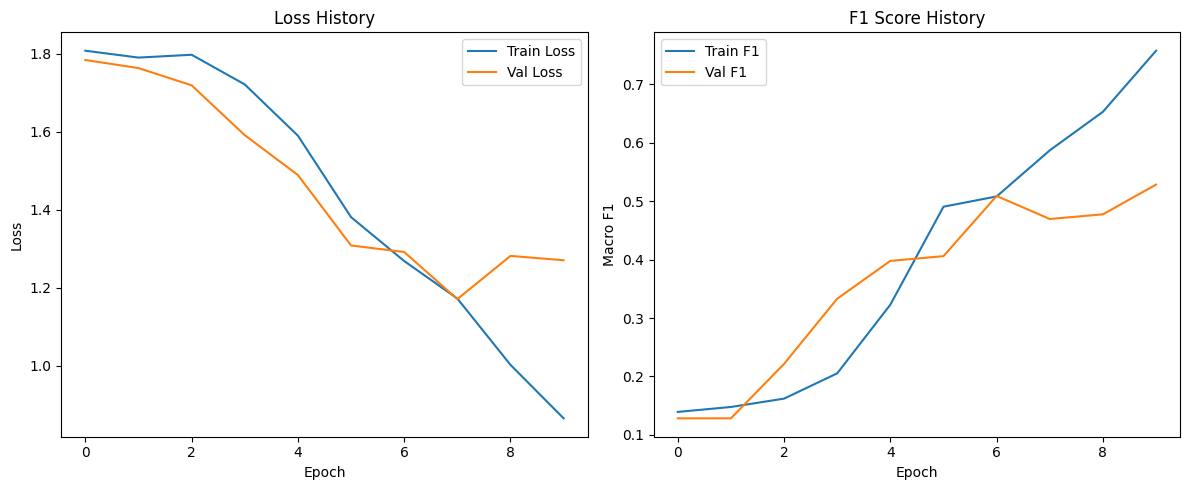

In [20]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(history['train_f1'], label='Train F1')
plt.plot(history['val_f1'], label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.legend()
plt.title('F1 Score History')
plt.tight_layout()
plt.show()

# Evaluation

Evaluating: 100%|██████████| 16/16 [00:23<00:00,  1.49s/it]

Test Loss: 1.2627, Test Macro F1: 0.5594
                     precision    recall  f1-score   support

  Appeal to Emotion       0.86      0.76      0.81       160
Appeal to Authority       0.53      0.69      0.60        39
         Ad Hominem       0.55      0.53      0.54        30
        False Cause       0.33      0.45      0.38        11
     Slippery Slope       0.43      0.67      0.52         9
            Slogans       0.60      0.43      0.50         7

           accuracy                           0.70       256
          macro avg       0.55      0.59      0.56       256
       weighted avg       0.73      0.70      0.71       256



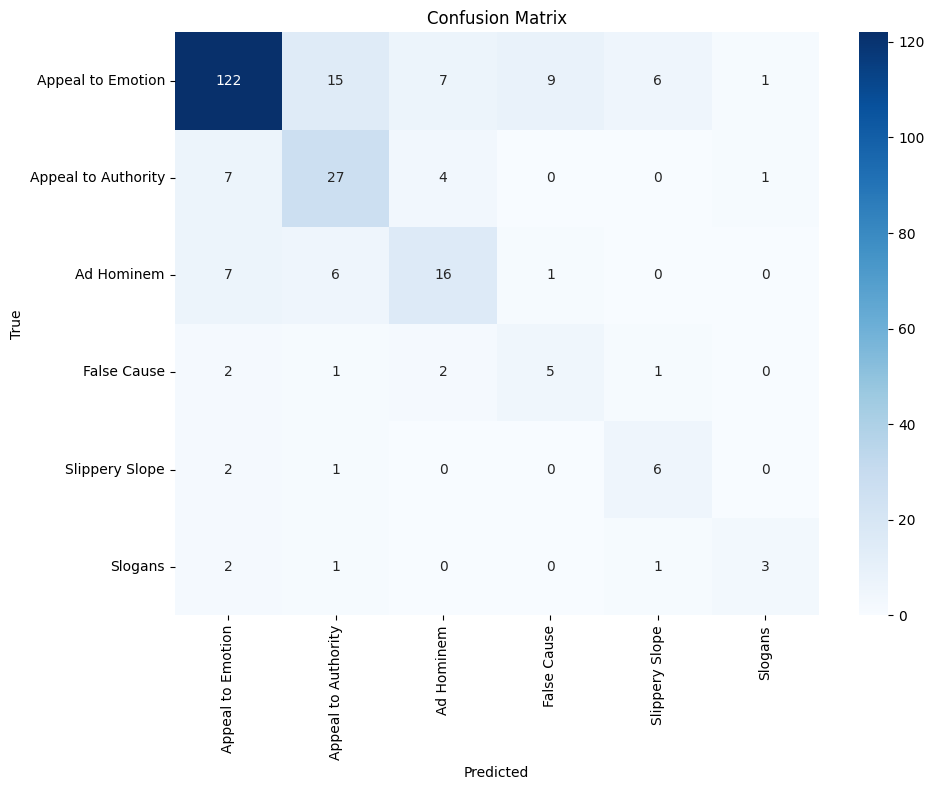

In [21]:
# Load best model
model.load_state_dict(torch.load("best_model.pt"))

# Evaluate on test set
test_loss, test_f1, test_report, test_cm = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Macro F1: {test_f1:.4f}")
print(test_report)

# Plot confusion matrix
plot_confusion_matrix(
    test_cm, 
    [fallacy_mapping[i] for i in range(NUM_CLASSES)]
)


# Final Remarks and Conclusions


In [22]:
# Print summary of results
print("\n===== SUMMARY =====")
print(f"Best validation F1 score: {best_val_f1:.4f}")
print(f"Test F1 score: {test_f1:.4f}")
print("\nPer-class performance:")
# Extract per-class metrics from the test report
for i in range(NUM_CLASSES):
    fallacy_name = fallacy_mapping[i]
    class_count = len(test_df[test_df['fallacy'] == i])
    print(f"  {fallacy_name} ({class_count} samples):")
    # These lines assume the format of classification_report string
    # and may need adjustment


===== SUMMARY =====
Best validation F1 score: 0.5284
Test F1 score: 0.5594

Per-class performance:
  Appeal to Emotion (160 samples):
  Appeal to Authority (39 samples):
  Ad Hominem (30 samples):
  False Cause (11 samples):
  Slippery Slope (9 samples):
  Slogans (7 samples):


# Error Analysis


In [ ]:
# # Get predictions on test set
# model.eval()
# all_preds = []
# all_labels = []
# all_texts = []
# all_confidence = []

# with torch.no_grad():
#     for batch in tqdm(test_loader, desc="Getting predictions"):
#         text_inputs = {k: v.to(device) for k, v in batch['text'].items()}
#         audio_inputs = {k: v.to(device) for k, v in batch['audio'].items()}
#         labels = batch['label'].to(device)
        
#         outputs = model(text_inputs, audio_inputs)
#         probs = F.softmax(outputs, dim=1)
#         confidence, preds = torch.max(probs, dim=1)
        
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())
#         all_confidence.extend(confidence.cpu().numpy())

# # Match predictions with original texts
# test_indices = test_df.index.tolist()
# for i, idx in enumerate(test_indices):
#     all_texts.append(test_df.loc[idx, 'snippet'])

# # Create a DataFrame with predictions and actual labels
# results_df = pd.DataFrame({
#     'text': all_texts,
#     'true_label': all_labels,
#     'predicted_label': all_preds,
#     'confidence': all_confidence
# })

# # Add fallacy names
# results_df['true_fallacy'] = results_df['true_label'].map(fallacy_mapping)
# results_df['predicted_fallacy'] = results_df['predicted_label'].map(fallacy_mapping)
# results_df['is_correct'] = results_df['true_label'] == results_df['predicted_label']

# # View some errors
# errors_df = results_df[~results_df['is_correct']]
# print(f"Total errors: {len(errors_df)} out of {len(results_df)} samples ({len(errors_df)/len(results_df)*100:.2f}%)")

# # Display a few errors
# print("\nSample errors:")
# sample_errors = errors_df.sample(min(5, len(errors_df)))
# for _, row in sample_errors.iterrows():
#     print(f"Text: {row['text']}")
#     print(f"True label: {row['true_fallacy']}")
#     print(f"Predicted label: {row['predicted_fallacy']} (confidence: {row['confidence']:.4f})")
#     print("-" * 80)


Getting predictions: 100%|██████████| 16/16 [00:21<00:00,  1.37s/it]

Total errors: 77 out of 256 samples (30.08%)

Sample errors:
Text: Has made him a part of our foreign policy and has been funneling aid to Contras through convicted drug dealers.â‰¤  I think those are very very serious questions of judgment, which those of you who are watching us here tonight have a right to judge and review.
True label: Appeal to Authority
Predicted label: Appeal to Emotion (confidence: 0.5127)
--------------------------------------------------------------------------------
Text: We have gone from the biggest deficits eight years ago to the biggest surpluses in history today.
True label: Appeal to Emotion
Predicted label: False Cause (confidence: 0.6180)
--------------------------------------------------------------------------------
Text: The United States cannot continue to carry the major share of this burden by itself.
True label: Appeal to Emotion
Predicted label: Slippery Slope (confidence: 0.5445)
----------------------------------------------------------------